# Paramagnetic Effects: Pseudo-Sontact Shift

In [9]:
import sys
sys.path.append('/Users/albertsmith/Documents/GitHub.nosync')
sys.path.append('/Users/albertsmith/Documents/GitHub')
import pyRelaxSim as RS
import numpy as np
import matplotlib.pyplot as plt

In [10]:
%matplotlib notebook

The shift in the NMR peak due to an isotropic coupling to the electron is known as the contact shift. The pseudo-contact shift is considerably more complex. Since it arises from the anisotropic part of the hyperfine coupling, an electron with quantization axis along the magnetic field's $z$-axis will not yield a pseudo-contact shift. This is because the average size of the orientationally-averaged coupling is zero. On the other hand, if, due to an anisotropic g-tensor, the electron's quantization axis is tilted away from $z$, then the anisotropic part of the hyperfine coupling to the nuclear will not fully average out. 

Actually simulating this effect is a bit difficult. First, we need the full tensors for the electrons, so we have to simulate in the lab frame. Second, our $T_1$ implementation always is applied to the Zeeman-defined states, but we actually require electron relaxation to occur along the quantization axis. Therefore, we induce the electron relaxation indirectly, via motion of the electron g-tensor (we still have to put the terms in to induce relaxation towards therm

<IPython.core.display.Javascript object>


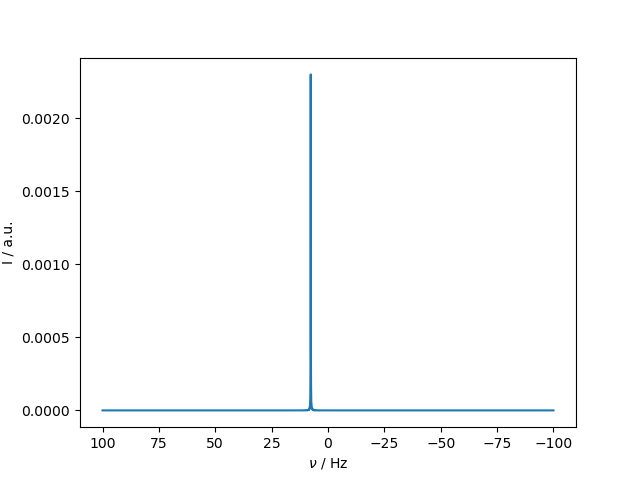

<AxesSubplot:xlabel='$\\nu$ / Hz', ylabel='I / a.u.'>

In [29]:
delta=2e4
g_euler=[0,2*np.pi/5,0]
gxx,gyy,gzz=1,1,4

ex=[]   #Since we have four states in exchange, we'll put them in a list
ex.append(RS.ExpSys(v0H=600,rotor_angle=0,vr=0,Nucs=['13C','e-'],T_K=300,LF=True,pwdavg=RS.PowderAvg('alpha0beta0')))     #1-spin system at 600 MHz (14.1 T). LF=True : Lab Frame
ex[-1].set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex[-1].set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz,euler=g_euler)

phi_tetra=np.arccos(-1/3)
for k in range(3):
    ex.append(ex[0].copy())
    ex[-1].set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta,euler=[0,phi_tetra,k*2*np.pi/3])
    ex[-1].set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz,euler=[g_euler,[0,phi_tetra,k*2*np.pi/3]])
    

L=RS.Liouvillian([ex[k] for k in [0,1,2,3]])
L.kex=RS.Tools.fourSite_sym(tc=1e-9)  #Four site symmetric exchange


L.add_relax(Type='T1',i=1,T1=1e-12)
L.add_relax(Type='T2',i=1,T2=1e-12)
L.add_relax(Type='recovery')

U=L.U(Dt=5e-3)

rho=RS.Rho(rho0='13Cx',detect='13Cp')
rho.DetProp(U,n=4000)
rho()
rho.downmix()
rho.plot(FT=True,apodize=True)

### Verify temperature dependence
We will re-run the above simulation, but as a function of temperature to confirm its dependence on the temperature

<IPython.core.display.Javascript object>


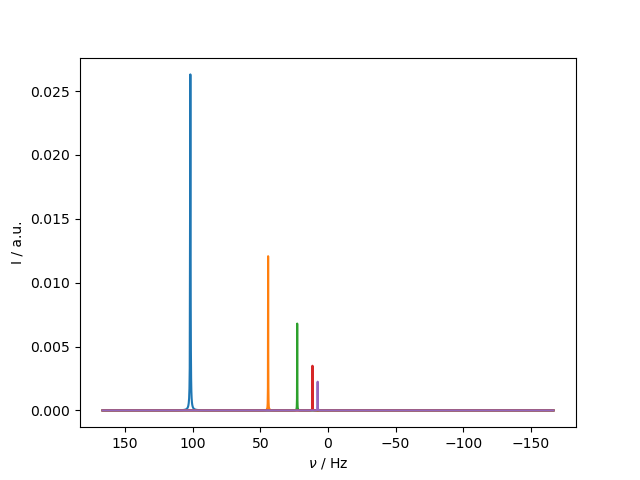

In [30]:
ax=plt.subplots(1,1)[1]
T0=[10,50,100,200,300]
for T in T0:
    L.expsys.T_K=T
    L.clear_relax()
    L.add_relax(Type='T1',i=1,T1=1e-12)  #Add T1 relaxation (1 ns). 
    L.add_relax(Type='T2',i=1,T2=1e-12) #Add T2 relaxation (ensure physical system)
    L.add_relax(Type='recovery')
    
    U=L.U(Dt=3e-3)

    rho=RS.Rho(rho0='13Cx',detect='13Cp')
    rho.DetProp(U,n=4000)
    rho()
    rho.downmix()
    rho.plot(ax=ax,FT=True,apodize=True)

### Is the g-tensor anisotropy required?
We'll re-run the above calculation with an isotropic g-tensor to see what impact this has

<IPython.core.display.Javascript object>


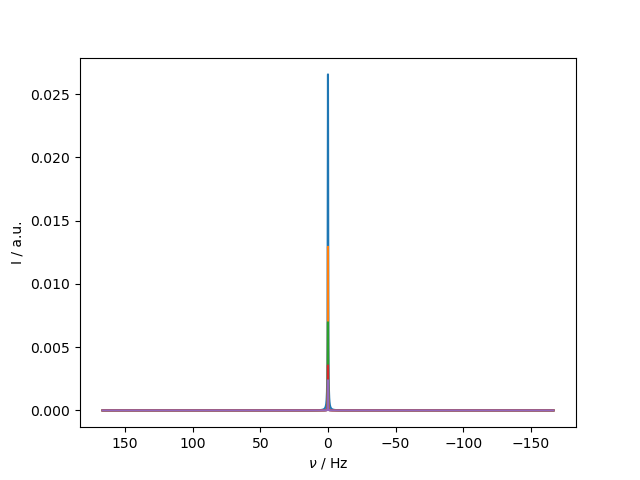

In [32]:
for ex0 in ex:
    ex0.set_inter('g',i=1,gxx=2,gyy=2,gzz=2)  #Set isotropic g-tensor

#We have to re-build the Liouvillian after editing interactions
L=RS.Liouvillian([ex[k] for k in [0,1,2,3]])
L.kex=RS.Tools.fourSite_sym(tc=1e-9)  #Four site symmetric exchange


ax=plt.subplots(1,1)[1]
T0=[10,50,100,200,300]
for T in T0:
    L.expsys.T_K=T
    L.clear_relax()
    L.add_relax(Type='T1',i=1,T1=1e-12)  #Add T1 relaxation (1 ns). 
    L.add_relax(Type='T2',i=1,T2=1e-12) #Add T2 relaxation (ensure physical system)
    L.add_relax(Type='recovery')
    
    U=L.U(Dt=3e-3)

    rho=RS.Rho(rho0='13Cx',detect='13Cp')
    rho.DetProp(U,n=4000)
    rho()
    rho.downmix()
    rho.plot(ax=ax,FT=True,apodize=True)

The effect has vanished, confirming that we do require anistropy of the g-tensor to tilt the electron quantization axis away from the magnetic field's $z$-axis

## Second attempt: Just add electron relaxation (??)

<IPython.core.display.Javascript object>


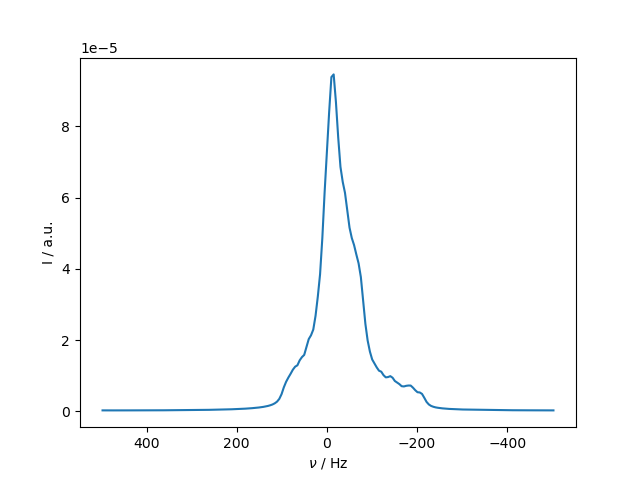

<AxesSubplot:xlabel='$\\nu$ / Hz', ylabel='I / a.u.'>

In [8]:
delta=2e4
gxx,gyy,gzz=1,1,4
g_euler=[0,2*np.pi/5,0]

ex=RS.ExpSys(v0H=600,vr=10000,Nucs=['13C','e-'],T_K=50,LF=True,pwdavg=RS.PowderAvg(q=8))
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex.set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz,euler=g_euler)

L=RS.Liouvillian(ex)

L.add_relax(Type='T1',i=1,T1=1e-9)
L.add_relax(Type='T2',i=1,T2=1e-12)
L.add_relax(Type='recovery')

U=L.U()**10

rho=RS.Rho(rho0='13Cx',detect='13Cp')
rho.DetProp(U,n=100)
rho.downmix()
rho.plot(FT=True,apodize=True)

<IPython.core.display.Javascript object>


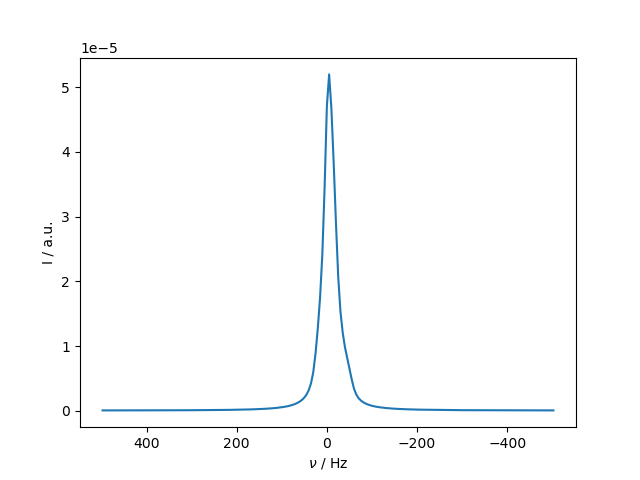

<AxesSubplot:xlabel='$\\nu$ / Hz', ylabel='I / a.u.'>

In [27]:
ex=RS.ExpSys(v0H=600,vr=10000,Nucs=['13C','e-'],T_K=200,LF=True,pwdavg=RS.PowderAvg(q=8))
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex.set_inter('g',i=1,gxx=1,gyy=1,gzz=4,euler=g_euler)

L=RS.Liouvillian(ex)

L.add_relax(Type='T1',i=1,T1=1e-9)
L.add_relax(Type='T2',i=1,T2=1e-12)
L.add_relax(Type='recovery')

U=L.U()**10

rho=RS.Rho(rho0='13Cx',detect='13Cp')
rho.DetProp(U,n=100)
rho.downmix()
rho.plot(FT=True,apodize=True)